# skip-gram

Word2Vec 모델 중 하나인 **skip-gram**을 파이토치로 구현합니다. 《밑바닥부터 시작하는 딥러닝 2》을 참고했습니다.

## PTB 데이터 불러오기

**펜 트리뱅크**(Penn Treebank, PTB) 데이터셋. word2vec 발명자인 토마스 미콜로프(Tomas Mikolov) 웹 페이지에서 받을 수 있습니다. 원래의 PTB 문장에 몇 가지 전처리가 되어있습니다. 희소한 단어는 `<unk>`로 치환되어 있다던가, 구체적인 숫자는 `N`으로 대체되어 있습니다.

In [0]:
import os

if 'ptb.train.txt' in os.listdir():
    with open("ptb.train.txt", 'r') as f:
        text = f.read()        
else:
    from urllib.request import urlopen
    url = 'https://raw.githubusercontent.com/tomsercu/lstm/master/data/ptb.train.txt'
    html = urlopen(url)
    text = html.read().decode()

    with open("ptb.train.txt", 'w') as f:
        f.write(text)
    

## 훈련셋 만들기

윈도우 내의 단어로 가운데 단어를 추론합니다. 여기서의 함수는 skip-gram 모델에서도 사용할 수 있습니다. skip-gram에서는 단순히 맥락과 타깃을 바꿔주기만 하면 됩니다.

### 함수 정의

In [0]:
import numpy as np

# 전처리
def preprocess(text):
    
    words = text.replace('\n', '<eos>').strip().split()
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

# 훈련셋 만들기
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size+1):
            if t == 0:
                continue
            cs.append(corpus[idx+t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

### 실행

In [0]:
window_size = 5

# 훈련셋 만들기
corpus, word_to_id, id_to_word = preprocess(text)
contexts, target = create_contexts_target(corpus, window_size)

## skip-gram, 훈련 모델 정의하기

In [0]:
import time
import matplotlib.pyplot as plt
import torch
from torch import nn, optim 
from torch.utils.data import TensorDataset, DataLoader


# 모델을 훈련할 때 사용할 클래스
class Trainer():
    def __init__(self, model, optimizer):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None        
        self.current_epoch = 0

    def fit(self, x, y, max_epoch=10, batch_size=32, verbose=True):
        x = torch.tensor(x)
        y = torch.tensor(y)
        dataset = TensorDataset(x, y)
        loader = DataLoader(dataset, batch_size, shuffle=True, drop_last=True)
        max_iters = len(loader)

        total_loss = 0
        start_time = time.time()
        for epoch in range(max_epoch):
            running_loss = 0
            for iters, (xx, yy) in enumerate(loader):
                xx = xx.to(self.device)
                yy = yy.to(self.device)
                loss = self.model(xx, yy, self.device)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            self.current_epoch += 1

            # 평가
            if verbose:
                avg_loss = total_loss / max_iters
                elapsed_time = time.time() - start_time
                print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 손실 %.3f'
                        % (self.current_epoch, iters + 1, max_iters, elapsed_time, avg_loss))
                self.loss_list.append(avg_loss)
                total_loss = 0

    def plot(self):
        x = np.arange(len(self.loss_list))
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()

# 네거티브 샘플링을 위한 클래스
class UnigramSampler():
    def __init__(self, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        corpus = torch.tensor(corpus)
        self.weight = torch.bincount(corpus).float() ** power
    
    def get_negative_sample(self, y):
        # 부정적 예에 타깃이 포함될 수 있다.
        # 계산량과 구현상 편의를 위해 아래와 같이 구현
        n_samples = torch.multinomial(self.weight, y.nelement()*self.sample_size, replacement=True)
        n_samples = n_samples.view(len(y), -1)
        return n_samples

# skip-gram 모델
class SkipGram(nn.Module):
    def __init__(self, corpus, hidden_size):
        super().__init__()
        
        V = len(np.unique(corpus))
        H = hidden_size
        
        # 계층 생성
        self.sampler = UnigramSampler(corpus)
        self.emb1 = nn.Embedding(V, H)
        self.emb2 = nn.Embedding(V, H)
        nn.init.normal_(self.emb1.weight, 0, 0.01)
        nn.init.normal_(self.emb2.weight, 0, 0.01)
        self.loss_fn = nn.BCEWithLogitsLoss(reduction='sum')
        
    def forward(self, x, y, device='cpu'):

        h = self.emb1(x) # batch size, embedding dim
        batch_size, hidden_dim = h.shape
        
        # 긍정 - CBOW와의 차이가 여기에 있다
        target_W = self.emb2(y)                                               # batch size, target size, embedding dim
        p_scores = torch.sum(h.view(batch_size, 1, hidden_dim) * target_W, 2) # batch size, target size
        p_loss = self.loss_fn(p_scores, torch.ones(p_scores.shape, device=device))

        # 부정
        n_samples = self.sampler.get_negative_sample(y).to(device)            # batch size, negative sample size
        target_W = self.emb2(n_samples)                                       # batch size, negative sample size, embedding dim
        n_scores = torch.sum(h * target_W.transpose(0, 1), 2) # negative sample size, batch size
        n_loss = self.loss_fn(n_scores, torch.zeros(n_scores.shape, device=device))
        
        # 평균 손실
        loss = (n_loss + p_loss) / (p_scores.nelement() + n_scores.nelement())
        
        return loss
    
    def word_vecs(self):
        return self.emb1.weight.data.cpu().numpy()

### 실행

In [5]:
hidden_size = 100
batch_size = 128
max_epoch = 15
verbose = True

# 모델 생성
model = SkipGram(corpus, hidden_size)
optimizer = optim.Adam(model.parameters())
trainer = Trainer(model, optimizer)

# target과 contexts를 CBOW와는 반대로 넣어준다.
target, contexts = contexts, target
trainer.fit(contexts, target, max_epoch, batch_size, verbose)

| 에폭 1 |  반복 7262 / 7262 | 시간 45[s] | 손실 0.425
| 에폭 2 |  반복 7262 / 7262 | 시간 91[s] | 손실 0.400
| 에폭 3 |  반복 7262 / 7262 | 시간 137[s] | 손실 0.394
| 에폭 4 |  반복 7262 / 7262 | 시간 182[s] | 손실 0.390
| 에폭 5 |  반복 7262 / 7262 | 시간 228[s] | 손실 0.387
| 에폭 6 |  반복 7262 / 7262 | 시간 273[s] | 손실 0.384
| 에폭 7 |  반복 7262 / 7262 | 시간 319[s] | 손실 0.382
| 에폭 8 |  반복 7262 / 7262 | 시간 365[s] | 손실 0.381
| 에폭 9 |  반복 7262 / 7262 | 시간 410[s] | 손실 0.380
| 에폭 10 |  반복 7262 / 7262 | 시간 456[s] | 손실 0.378
| 에폭 11 |  반복 7262 / 7262 | 시간 502[s] | 손실 0.378
| 에폭 12 |  반복 7262 / 7262 | 시간 547[s] | 손실 0.377
| 에폭 13 |  반복 7262 / 7262 | 시간 593[s] | 손실 0.376
| 에폭 14 |  반복 7262 / 7262 | 시간 638[s] | 손실 0.376
| 에폭 15 |  반복 7262 / 7262 | 시간 684[s] | 손실 0.375


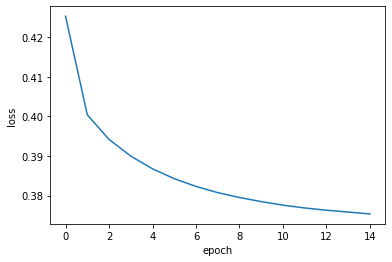

In [6]:
trainer.plot()

## 평가

특정 단어를 넣었을 때 유사한 단어를 가려낼 수 있는지, 그리고 단어 간 비유적 관계를 찾아낼 수 있는지를 볼 것입니다.

### 함수 정의

In [0]:
def most_similar(query, word_to_id, id_to_word, similarity_matirx, top=5):
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return
    
    print('\n[query] ' + query)
    query_id = word_to_id[query]
    similarity = similarity_matirx[query_id]
    
    # 코사인 유사도 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))
        
        count += 1
        if count >= top:
            return

def analogy(a, b, c, word_to_id, id_to_word, word_vecs, top=5):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s(을)를 찾을 수 없습니다.' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_vecs[word_to_id[a]], word_vecs[word_to_id[b]], word_vecs[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    word_vecs_norm = word_vecs / np.linalg.norm(word_vecs, axis=1, keepdims=True)
    similarity = np.dot(word_vecs_norm, query_vec)

    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

### 실행

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

word_vecs = model.word_vecs()
similarity_matirx = cosine_similarity(word_vecs)

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, similarity_matirx)


[query] you
 i: 0.69232154
 your: 0.65297306
 yourself: 0.6527038
 anybody: 0.62820214
 do: 0.61197925

[query] year
 month: 0.6314531
 earlier: 0.6273992
 week: 0.5166726
 decade: 0.4956562
 fiscal: 0.49133912

[query] car
 cars: 0.6072693
 luxury: 0.5414275
 chevrolet: 0.5100602
 auto: 0.5083307
 corsica: 0.501513

[query] toyota
 motor: 0.6842423
 lexus: 0.6364988
 honda: 0.61917984
 infiniti: 0.6056482
 nissan: 0.58814454


In [9]:
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)


[analogy] king:man = queen:?
 road: 2.6660079956054688
 rage: 2.601775646209717
 bikers: 2.5797839164733887
 hat: 2.520460605621338
 weather: 2.372321605682373

[analogy] take:took = go:?
 went: 2.072838306427002
 stands: 1.9286367893218994
 moved: 1.8612631559371948
 trap: 1.8375418186187744
 got: 1.7516160011291504

[analogy] car:cars = child:?
 children: 2.699692487716675
 audiences: 2.359595775604248
 conception: 2.312422752380371
 sleep: 2.2767601013183594
 psychiatric: 2.2132794857025146

[analogy] good:better = bad:?
 those: 1.7770507335662842
 worse: 1.6371487379074097
 left: 1.5435960292816162
 involved: 1.5154612064361572
 done: 1.4858317375183105
